<a href="https://colab.research.google.com/github/samrat-halder/Singapore-House-Prices-with-XGBoost/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lovelytics**
## Singapore Re-Sale Housing Price Prediction using XGBoost
Summer Internship 2020

---


Submitted by: Samrat Halder (MS Data Science, Columbia University)

# Imports

In [1]:
%matplotlib inline
#!pip install category_encoders
from google.colab import drive
import os
import sys
import time
import pandas as pd
import numpy as np
import pickle
import re
from copy import deepcopy
from matplotlib import pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder # Usually needs to downloaded
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

pd.options.mode.chained_assignment = None
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/Lovelytics")
pd.set_option('display.max_rows', 5)
import warnings
warnings.filterwarnings("ignore") #XGBoost warning

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Functions
Below I define some helper functions that I will use throughout my analysis. For example, this includes functions to read in the data with checks and standardize text. Descriptions for each function can be found in their body

In [0]:
def readFile(path='', format='', save=False, outputFile='all_resale_data.pkl'):
  """
  Reads all the .csv/ .pkl files in a directory.
  Saves data to pkl.  
  :params path: (str)path of the directory containing data
  :params format: (str) csv or pkl
  :params save: True or False if true then saves the full df to pkl
  :params outputFile: (Str) name of the output pkl file
  :return : full df
  """
  print('Loading data..')
  df =None
  if path == '' or format == '':
    raise ValueError('Please provide path name and file format.')
  elif format not in ['csv', 'pkl']:
    raise ValueError('Please prove correct format for files.')
  elif not os.path.isdir(path):
    raise ValueError('The path provided does not exist.')
  else:
    if format == 'csv':
      for file in os.listdir(path):
        if file.endswith('.csv'):
          df_ = pd.read_csv(os.path.join(path, file))
          if df is not None:
            df = pd.concat([df, df_], ignore_index=True)
          else:
            df = df_
    elif format == 'pkl':
      for file in os.listdir(path):
        if file.endswith('.pkl'):
          df_ = pd.read_pickle(os.path.join(path,file))
          if df is not None:
            df = pd.concat([df, df_], ignore_index=True)
          else:
            df = df_
    if save:
      pd.to_pickle(df, os.path.join(path, outputFile))
    print('done!')
    return df

def textStandarizer(text):
  """
  Converts all the characters to lowercase
  Replace all non alpha numeric characters by '_'
  Removes all extra white spaces
  :params text: 
  :return : standarized cleaned text
  """

  #some strings are present both in uppercase and lowercase (eg. town names )
  text = str(text).lower() 
  text = '_'.join(text.split()) #removes extra white spaces and joins all strings by single "_"
  text = re.sub('[^0-9a-zA-Z_]+', '_', text) #replace all non alphanumerics by "_"

  return text

def preprocess(df, type='', init_="2008-04-01", verbose=True):
  """
  Preprocessing and feature engineering of various sources of data
  :params df: input dataframe
  :params type: (str) resale (data containing resale prices) or median (data containing median prices)
  :params init_: (str) Date before from which the data will be truncated default = 2008-04-01 
  :params verbose: True or False, if True prints first three rows of the processed data
  """
  print('Processing data..')
  if type == '':
    raise ValueError('Please enter a datafram type eg. resale, median')
  elif type == 'resale':
    #data frame containing resale prices
    df['month'] = pd.to_datetime(df['month'], format='%Y-%m') #convert to datetime
    #Keep data after Jan 2008 since most of the dataset available after Apr 2007
    df = df[df['month'] >= init_]
    #df['floor_area_sqm'] = np.log(1+df['floor_area_sqm'])
    #add feature: no. of years since lease started
    df['years_past_lease'] = df['month'].dt.year - data['lease_commence_date']
    df['year'] = df['month'].dt.year.astype('str')
    #add feature: quarter
    df['quarter'] = df['month'].dt.month
    #create a separate column for month (month of the year)
    df['moy'] = df['quarter']
    # change quarter column from month to quarter
    df.loc[df['quarter'].isin([1,2,3]), 'quarter'] = 'q1'
    df.loc[df['quarter'].isin([4,5,6]), 'quarter'] = 'q2'
    df.loc[df['quarter'].isin([7,8,9]), 'quarter'] = 'q3'
    df.loc[df['quarter'].isin([10,11,12]), 'quarter'] = 'q4'
    df['remaining_lease'] = df['remaining_lease'].str[0:2].astype('float') 
    df.index = df['month'].dt.strftime('%Y-%m')

    #remove columns that are not important
    df.drop(columns=['month', 'lease_commence_date'], inplace=True) #'remaining_lease', 
    #for cols that contains string apply text processing 
    for col in df.columns:
      if df[col].dtype == 'object':
        df[col] = df[col].apply(textStandarizer)
    df = df.sort_index()
    if verbose:
      print('Printing first three rows of the data frame:')
      print(df[0:3])
  elif type == 'median':
    #remove 'na', '-', and NaNs from price column
    df = df[~df['price'].isin(['na', '-'])]
    df = df.dropna()
    df['price'] = pd.to_numeric(df['price']) #to numeric
    #apply the text processor
    for col in df.columns:
      if df[col].dtype == 'object':
        df[col] = df[col].apply(textStandarizer)
    #edge case 1: central area and central are same
    df.loc[df['town'] == 'central', 'town']  = 'central_area'
    #edge case 2: exec and executive are same
    df.loc[df['flat_type'] == 'exec', 'flat_type'] = 'executive'
    #renamce quarter and price for better understanding
    df.rename(columns={'quarter': 'year_q', 'price' : 'median_price'}, inplace=True)
    df.sort_values(by='year_q', inplace=True)
    if verbose:
      print('Printing first three rows of the data frame:')
      print(df[0:3])
  elif type == 'application':
    df = df.dropna()
    for col in df.columns:
      if df[col].dtype == 'object':
        df[col] = df[col].apply(textStandarizer)
    df.loc[df['flat_type'] == 'exec', 'flat_type'] = 'executive'
    df.rename(columns={'quarter': 'year_q'}, inplace=True)
    df.sort_values(by='year_q', inplace=True)
    if verbose:
      print('Printing first three rows of the data frame:')
      print(df[0:3])
  else:
    raise ValueError('Invalid data frame type.')
  print('done!')
  return df

def getYearQt(last_q, last_y):
  """
  Get next (year, quarter) tuple
  Used in rollByQuarter func
  """
  if last_q == 4:
    next_y = last_y + 1
    next_q = 1
  else:
    next_y = last_y
    next_q = last_q + 1
  return next_q, next_y

def rollByQuarter(df_, period=4, cols_=[], index_col_='', target_col_=''):
  """
  Function to roll the data by n quarter forward for macro variables
  :params df_: input dataframe
  :params period: (int) Number of period by which the data frame to be rolled 
  forward default value 4 ie. 4 quarters or 1 year
  :parms cols_: (list) A list of columns containing catergorical variables. At the moment
  only accepts one or two column names #TODO generalize for any number of columns if required 
  :params index_col_: (str) columns containing year and quarter in one string eg. 2009_q1
  :params target_col_: (str) column which is not there in index_col_ and cols (eg. median_price)
  """
  
  if not cols_:
    raise ValueError('Enter the name of the grouping columns.')
  if len(cols_) > 2:
    raise ValueError('Max number of columns permitted is two.')
  if not index_col_:
    raise ValueError('Enter the name of year_quarter column.')
  df = None
  df_.sort_values(by=index_col_, inplace=True) #sort dataframe by year and quarter
  if len(cols_) == 2:
    list1 = list(df_[cols_[0]].unique())
    list2 = list(df_[cols_[1]].unique())
    #For each value of the columns of cols_ list we filter the dataframe
    #and roll forward by 4 quarters 
    for l1 in list1:
      for l2 in list2:
        tmp = df_[(df_[cols_[0]] == l1) & (df_[cols_[1]] == l2)]
        if len(tmp) > 0: #edge case: invalid column combination 
          #edge case: add next n period year quarter rows to avoid missing data
          last_yq = tmp[index_col_].tolist()[-1]
          last_y = int(last_yq[:4])
          last_q = int(last_yq[-1])
          for i in range(period):
            last_q, last_y = getYearQt(last_q, last_y)
            y_q_str = str(last_y) + '_q' + str(last_q)
            row = {index_col_: y_q_str, cols_[0]: l1, cols_[1]: l2, target_col_: 0}
            tmp = tmp.append(row, ignore_index=True)

          tmp.index = tmp[index_col_]     #set index to year_quarter col
          tmp = tmp.shift(periods=period) #roll forward by n periods
          tmp[index_col_] = tmp.index     #update the year_quarter column values by dataframe index
          tmp.dropna(inplace=True)        #drop NaNs
          tmp.reset_index(drop=True, inplace=True)      
          if df is not None:
              df = pd.concat([df, tmp], ignore_index=True) 
          else:
              df = tmp
  
  elif len(cols_) == 1:
    list1 = list(df_[cols_[0]].unique())
    for l1 in list1:
      tmp = df_[df_[cols_[0]] == l1]
      #edge case: add next n period year quarter rows to avoid missing data
      last_yq = tmp[index_col_].tolist()[-1]
      last_y = int(last_yq[:4])
      last_q = int(last_yq[-1])
      for i in range(period):
        last_q, last_y = getYearQt(last_q, last_y)
        y_q_str = str(last_y) + '_q' + str(last_q)
        row = {index_col_: y_q_str, cols_[0]: l1, target_col_: 0}
        tmp = tmp.append(row, ignore_index=True)

      tmp.index = tmp[index_col_]     #set index to year_quarter col
      tmp = tmp.shift(periods=period) #roll forward by n periods
      tmp[index_col_] = tmp.index     #update the year_quarter column values by dataframe index
      tmp.dropna(inplace=True)        #drop NaNs
      tmp.reset_index(drop=True, inplace=True)
      if df is not None:
          df = pd.concat([df, tmp], ignore_index=True)
      else:
          df = tmp
  #split year and quarter into two different columns
  df['year'], df['quarter'] = df[index_col_].str.split('_', 1).str
  df.drop(columns=[index_col_], inplace=True) #drop the year_quarter column 

  return df   

def missingValues(df):
  """
  Reference : Stackoverflow
  Output a summary of missing values for all the columns
  :params input: data frame
  :return : data containing missing value summary 
  """

  mis_val = df.isnull().sum()
  mis_val_percent = 100 * df.isnull().sum() / len(df)
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
  mis_val_table_ren_columns = mis_val_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'})
  mis_val_table_ren_columns = mis_val_table_ren_columns[
      mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
  '% of Total Values', ascending=False).round(1)
  print(f"Dataframe has {str(df.shape[1])} columns.\n \
            There are {str(mis_val_table_ren_columns.shape[0])} \
            columns that have missing values.")
  return mis_val_table_ren_columns 

def trainTest(df, test_year=2018, n_prev=5, rest_all=False):
  """
  Split the data into train-test keeping the forward order 
  :param df: input dataframe
  :param test_year: (int) year for which to test
  :param n_prev: (int) number of previous years which to be used for train-validation
  :return : X_train, X_test, y_train, y_test
  """

  df['year'] = pd.to_numeric(df['year'])
  train = df[(df['year'] < test_year) & (df['year'] >= (test_year-n_prev))]
  if rest_all:
    test = df[df['year'] >= test_year]
  else: 
    test = df[df['year'] == test_year]

  X_train, X_test = train.loc[:, train.columns != 'resale_price'], test.loc[:, test.columns != 'resale_price']

  #(Pipeline) 
  #Target encoding for block (2409) and street_name (547) since the cardinality is high
  te = TargetEncoder(cols=['block', 'street_name']).fit(X_train, train['resale_price'])
  X_train = te.transform(X_train)
  X_test = te.transform(X_test)
  #take log(resaleprice + 1) since resale price is skewed
  y_train, y_test = np.log1p(train['resale_price']), np.log1p(test['resale_price'])

  return X_train, X_test, y_train, y_test

def getFeatures(df, oneHotEn= []):
  """
  Function to preprocessing and feature engineering
  :param df : input data
  :param oneHotEn : (list) List of columns for one hot encoding
  :return : data frame and list of features
  """

  df = pd.get_dummies(df, columns=oneHotEn)
  features = set(df.columns) - {'resale_price'}

  return df, list(features)


def toWeight(y):
  """
  Calculates the weights for RMSPE calculation
  """
  w = np.zeros(y.shape, dtype=float)
  ind = y != 0
  w[ind] = 1./(y[ind]**2)
  return w

def rmspeXgb(yhat, y):
  """
  Calculate RMSPE for regressor with output variable
  :params yhat: (XGBoost DMatrix or series object)predicted value of y
  :params y: true value of y
  :output : A tuple if called from XGBoost model or a float otherwise
  """
  flag = False # the flag is to switch the return type based on
                # if y is series object or xgboost DMatrix object
  if not isinstance(y, pd.Series):
    flag = True
    y = y.get_label()
  y = np.expm1(y)
  yhat = np.expm1(yhat)
  w = toWeight(y)
  rmspe = np.sqrt(np.mean(w * (y - yhat)**2))

  return ("rmspe", rmspe) if flag else rmspe

def percentError(yhat, y):
  """
  Calculates percentage error at every data
  :params yhat: perdictions
  :params y: actual values (test data)
  :returns : percentage error array
  """
  w = np.zeros(y.shape, dtype=float)
  y = np.expm1(y)
  yhat = np.expm1(yhat)
  ind = y != 0
  w[ind] = 1./y[ind]
  error = w * (y - yhat) * 100
  return error

def calibrateModel(yp_valid, y_train):
  """
  Calibrates the predicted price
  It does an affine transformation (with linear assumption) of (predicted_price - avg(price)) in the training dataset 
  to (0.99, 1.01)
  Ref: https://math.stackexchange.com/questions/377169/going-from-a-value-inside-1-1-to-a-value-in-another-range
  While calibration no validation/ test data set is used to avoid information leakage
  :params : yp_valid : y_predicted on the validation or test data
  :params : y_train
  :return : return corrected prediction for test set
  """
  avg = np.mean(y_train) #avg of true prices in the training data
  y_trainMavg = y_train - avg 
  mx, mn = max(y_trainMavg), min(y_trainMavg)
  fact = ((yp_valid - avg) - mn)*(1.01-0.99)/ (mx-mn) + 0.99

  return fact * yp_valid

def XGBoost(X_train, X_test, y_train, y_test, features, verbose=True):
  """
  Train and validate/ test XGBoost model
  :params : X_train, X_test, y_train, y_test
  :params features: (list) A list of feature names
  :params verbose: True or False, if True it will print errors after each iteration
  :return : trained model, prediction for test and train data
  """
  params = {"objective": "reg:squarederror", # for linear regression
            "eta": 0.03,            # learning rate
            "max_depth": 8,        # maximum depth of a tree 3, 5, 7, 10, 13, 15
            "subsample": 0.9,       # Subsample ratio of the training instances 0.5,0.7,0.9, 1.0
            "colsample_bytree": 0.7,# Subsample ratio of columns when constructing each tree 0.3, 0.5, 0.6, 0.7, 0.9, 1
            "verbosity": 1,         # silent mode
            "lambda":1,             #L2 regularization 1, 5, 10
            "alpha": 0              #L1 regularization 1, 5, 10
            }
  num_trees = 250 #100, 200, 350, 450, 700

  dtrain = xgb.DMatrix(X_train[features], y_train)
  dtest = xgb.DMatrix(X_test[features], y_test)
  watchlist = [(dtrain, 'train'), (dtest, 'eval')]
  if verbose:
    print('Traing model..')
    gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, 
                    early_stopping_rounds=50, feval=rmspeXgb, verbose_eval=True)
    print('=====================================================================')
    print('Validation..')
  else:
    print('Training final model on data till 2018...')
    gbm = xgb.train(params, dtrain, num_trees)
    print('Predicting on test set')

  y_pred_test = gbm.predict(xgb.DMatrix(X_test[features]))
  y_pred_train = gbm.predict(xgb.DMatrix(X_train[features]))
  error_train = rmspeXgb(y_pred_train, y_train)
  print(f'Train RMSPE {round(error_train,4)}')
  error_test = rmspeXgb(y_pred_test, y_test)
  print(f'Test RMSPE {round(error_test,4)}')

  return gbm, y_pred_test, y_pred_train

## Load Resale Price data (Published monthly)
All data available here: https://data.gov.sg/dataset/resale-flat-prices

In [3]:
data = readFile(path='./data/resale-flat-prices', format='pkl', save=False)

Loading data..
done!


In [4]:
data.describe(include='all')
#data[['month', 'remaining_lease']].dropna()['month'].unique() (2015-2019)

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,remaining_lease,resale_price,storey_range,street_name,town
count,812704,812704,812704,812704.0,812704.0,812704,103650.0,812704.0,812704,812704,812704
unique,2409,33,8,NaN,NaN,361,663.0,NaN,25,563,27
...,...,...,...,...,...,...,...,...,...,...,...
75%,NaN,NaN,NaN,114.0,1993.0,NaN,NaN,380000.0,NaN,NaN,NaN
max,NaN,NaN,NaN,307.0,2016.0,NaN,NaN,1205000.0,NaN,NaN,NaN


In the dataset **remaining_lease** columns has a large amount of missing data. This column only contians values after 2015-. But when I inspect the preriod 2015-2019, still this column has got more than 50% rows missing. Therefore I will exclude it from my analysis.

In [5]:
#Preprocess, drop irrelivant features, add new features
data = preprocess(data, type='resale', init_="2008-01-01", verbose=True)
#Rearranging columns
data = data[['year', 'moy', 'quarter', 'years_past_lease', 'block', 'flat_model', 
             'flat_type', 'floor_area_sqm', 'storey_range', 'town', 'street_name', 
             'resale_price']] # drop 'remaining_lease'

Processing data..
Printing first three rows of the data frame:
        block flat_model  flat_type  ...  year  quarter  moy
month                                ...                    
2008-01   406   improved     2_room  ...  2008       q1    1
2008-01   305  apartment  executive  ...  2008       q1    1
2008-01   303  apartment  executive  ...  2008       q1    1

[3 rows x 13 columns]
done!


In [6]:
print(data.dtypes)
data.describe(include='all')

year             object
moy               int64
                 ...   
street_name      object
resale_price    float64
Length: 12, dtype: object


,year,moy,quarter,years_past_lease,block,flat_model,flat_type,floor_area_sqm,storey_range,town,street_name,resale_price
count,273920,273920.0,273920,273920.0,273920,273920,273920,273920.0,273920,273920,273920,273920.0
unique,13,NaN,4,NaN,2409,20,7,NaN,25,26,547,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
75%,NaN,9.0,NaN,31.0,NaN,NaN,NaN,113.0,NaN,NaN,NaN,475000.0
max,NaN,12.0,NaN,54.0,NaN,NaN,NaN,280.0,NaN,NaN,NaN,1205000.0


# Check distribution of continuous features in data
1. Resale price is right skewed -- closely follows a log normal distribution. 
2. **Floors Sq Area** and **Years passed since lease start** have got a few spikes

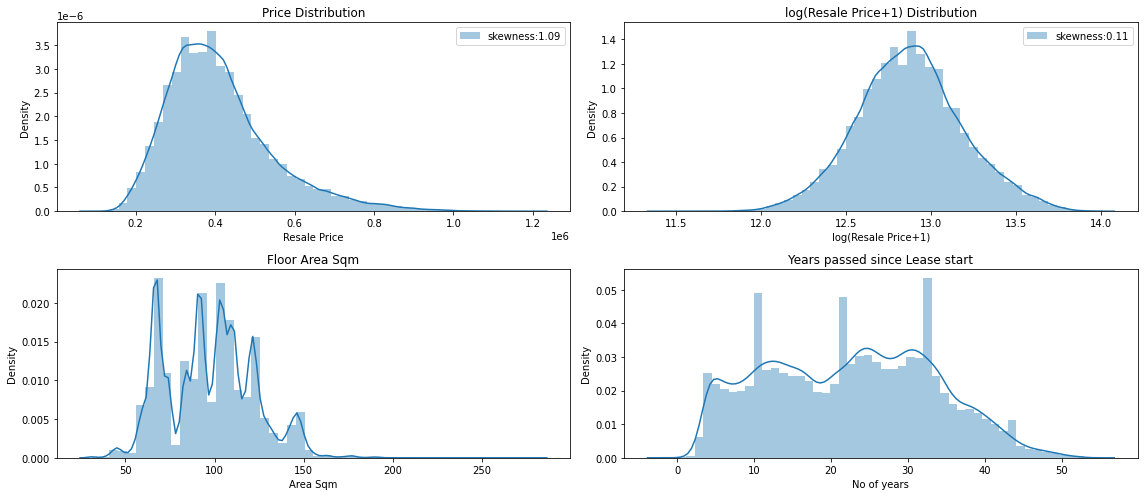

In [7]:
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
g1 = sns.distplot(data['resale_price'],hist = True,label='skewness:{:.2f}'.format(data['resale_price'].skew()),ax = ax1)
g1.legend()
g1.set(xlabel = 'Resale Price', ylabel = 'Density', title = 'Price Distribution')
g2 = sns.distplot(np.log1p(data['resale_price']),hist = True,label='skewness:{:.2f}'.format(np.log1p(data['resale_price']).skew()),ax=ax2)
g2.legend()
g2.set(xlabel = 'log(Resale Price+1)',ylabel = 'Density', title = 'log(Resale Price+1) Distribution')
g3 = sns.distplot(data['floor_area_sqm'],hist = True, ax = ax3)
g3.set(xlabel = 'Area Sqm', ylabel = 'Density', title = 'Floor Area Sqm')
g4 = sns.distplot(data['years_past_lease'],hist = True, ax = ax4)
g4.set(xlabel = 'No of years', ylabel = 'Density', title = 'Years passed since Lease start')
plt.tight_layout()
plt.show()

# Other relevant data
I found HDB's website very resourceful containing various macro data pertaining to Singapore housing market.


---
1. Median Prices by town and flat type (Quarterly published)
2. Number of Resale Applications Registered by Flat Type (Quarterly published)
3. HDB Resale Price Index (Quarterly published)
4. Resale Transaction by Flat Type (based on registered cases) (Annually published)
   etc.

Intuitions: 
1. I believe (1) is most important and informative since we have quarterly data by town and flat type (granular). Furthermore it depicts the level for overall housing market. Note: This data is published only at the end of the quarter.
2. (1) and (3) are directly correlated. Since for (1) we have more granular data I do not intend to use (3)
3. (2) is representative of market demand at a macro level.  
4. (2) and (4) are apparently correlated as clearly visible from the HDB's website. So since for (2) we have more granular data (quarterly) I choose (2) to be included in my analysis.



## 1. Explore Median Prices

In [8]:
median_data = readFile(path='./data/median-resale-prices-for-registered-applications-by-town-and-flat-type', format='csv', save=False)
median_data = preprocess(median_data, type='median', verbose=True)

Loading data..
done!
Processing data..
Printing first three rows of the data frame:
      year_q        town  flat_type  median_price
2    2007_q2  ang_mo_kio     3_room        172000
124  2007_q2    sengkang     5_room        300000
119  2007_q2   sembawang  executive        334000
done!


From the below trend of mean of the median prices (for all the flats across the nation) it seems till **2012q3** there was a uptrend. Since 2013 it has remained almost flat or stationary.

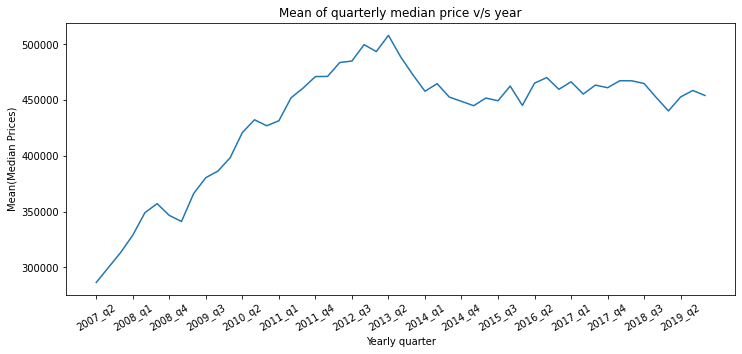

In [9]:
quarter = median_data[['year_q', 'median_price']].groupby(by=['year_q'], as_index=False).mean()
fig = plt.figure(figsize=(12,5))
plt.plot(quarter['year_q'], quarter['median_price'])
plt.xlabel('Yearly quarter')
plt.ylabel('Mean(Median Prices)')
plt.title('Mean of quarterly median price v/s year')
_ = plt.xticks(quarter['year_q'][::3])
_ = plt.xticks(rotation=30)

Similar trend for mean of median prices is observed across all the towns as expected.

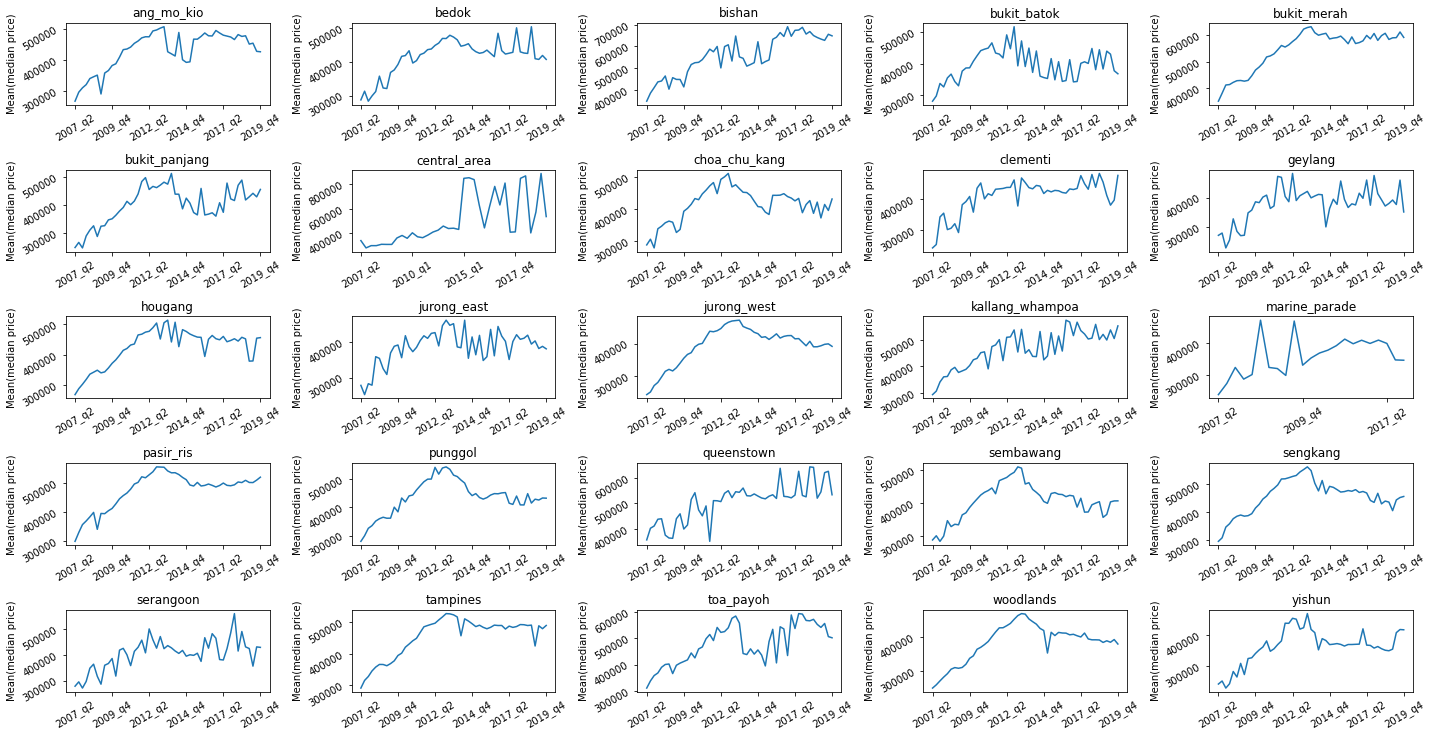

In [10]:
quarter_town = median_data[['year_q', 'town', 'median_price']].groupby(by=['year_q', 'town'], as_index=False).mean()
towns = quarter_town['town'].unique().tolist()
fig = plt.figure(figsize=(20,20))
for i, town in enumerate(towns, 1):
  plt.subplot(10, 5, i)
  tmp = quarter_town[quarter_town['town'] == town]
  plt.plot(tmp['year_q'], tmp['median_price'])
  plt.xticks(tmp['year_q'][::10])
  plt.xticks(rotation=30)
  plt.yticks(rotation=30)
  plt.ylabel('Mean(median price)')
  plt.title(str(town))
plt.tight_layout()

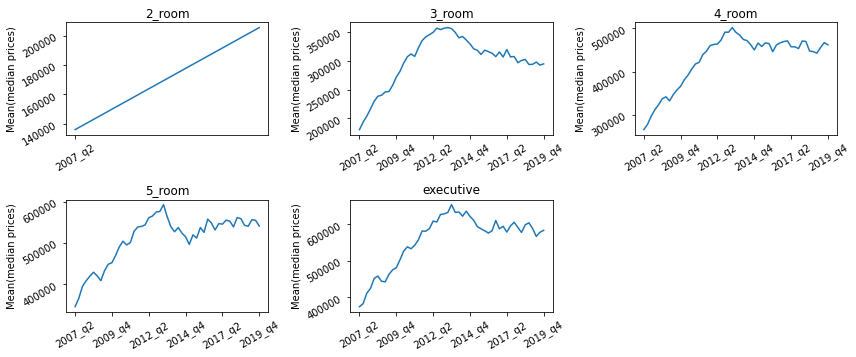

In [11]:
quarter_flat_type = median_data[['year_q', 'flat_type', 'median_price']].groupby(by=['year_q', 'flat_type'], as_index=False).mean()
flat_types = quarter_flat_type['flat_type'].unique().tolist()
fig = plt.figure(figsize=(12,7))
for i, flat in enumerate(flat_types, 1):
  plt.subplot(3, 3, i)
  tmp = quarter_flat_type[quarter_flat_type['flat_type'] == flat]
  plt.plot(tmp['year_q'], tmp['median_price'])
  plt.xticks(tmp['year_q'][::10])
  plt.xticks(rotation=30)
  plt.yticks(rotation=30)
  plt.ylabel('Mean(median prices)')
  plt.title(str(flat))
plt.tight_layout()

## 2. Explore Number of Resale Applications
This directly carries information about overall market demand and hence I include this in the analysis. 

In [12]:
app_data = readFile(path='./data/number-of-resale-applications-registered-by-flat-type-quarterly', format='csv', save=False)
app_data = preprocess(app_data, type='application', verbose=True)

Loading data..
done!
Processing data..
Printing first three rows of the data frame:
    year_q flat_type  no_of_resale_applications
0  2007_q1    1_room                          5
1  2007_q1    2_room                         67
2  2007_q1    3_room                       1908
done!


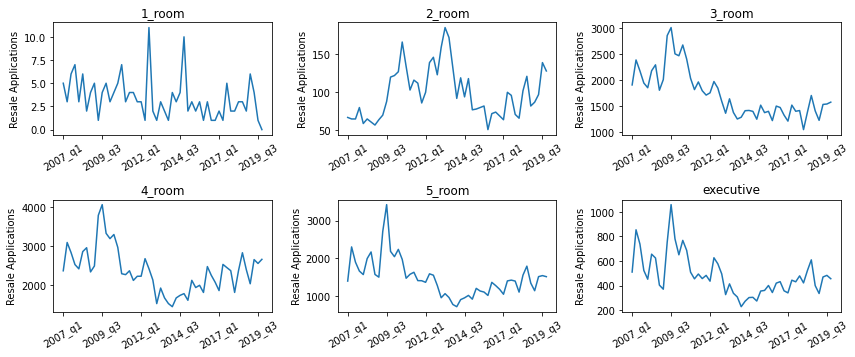

In [13]:
flat_types = app_data['flat_type'].unique().tolist()
fig = plt.figure(figsize=(12,7))
for i, flat in enumerate(flat_types, 1):
  plt.subplot(3, 3, i)
  tmp = app_data[app_data['flat_type'] == flat]
  plt.plot(tmp['year_q'], tmp['no_of_resale_applications'])
  plt.xticks(tmp['year_q'][::10])
  plt.xticks(rotation=30)
  plt.ylabel('Resale Applications')
  plt.title(str(flat))
#_ = fig.suptitle('Number of resale applications')
plt.tight_layout()

# Add more features from relevant datasets
1. Previously we added new feature years_past_lease : number of years passed since lease starting date
2. Add the quarterly mean of median prices as a feature 
3. Add quarterly number of resale applications as a feature
3. But both these data are published quarterly. Since our task is to predict one year ahead, hence we can only have data till present while running our model for next one year. Hence I use previous year same quarter data as a feature in my model. (*Assumption: When doing the prediction start from next quarter, we have data till current quarter available to us*)

In [14]:
#quarter_town_type = median_data.groupby(by=['year_q', 'town', 'flat_type'], as_index=False).mean()
median_q_town_type = rollByQuarter(median_data, cols_=['town', 'flat_type'], index_col_='year_q', period=4, target_col_='median_price')
print(median_q_town_type.shape)

(3580, 5)


In [15]:
app_q_type = rollByQuarter(app_data, cols_=['flat_type'], index_col_='year_q', period=4, target_col_='no_of_resale_applications')
print(app_q_type.shape)

(312, 4)


## Merge data from Median Prices and Number of Applications with Resale Price
Use last year same quarter **mean of median prices (grouped by  town and flat_type)** and **Number of applications (grouped by flat type)** as *features*. This seem to be an very important feature for the next year resale price prediction. The intuition is also supported by XGBoost feature importance. Also we see there is a strong correlation of these features with the Resale Price.

In [0]:
data_merged = pd.merge(data, median_q_town_type, how='left', on=['year', 'quarter', 'town', 'flat_type'] )
data_merged = pd.merge(data_merged, app_q_type, how='left', on=['year', 'quarter', 'flat_type'] )
data_merged.drop(columns=['quarter'], inplace=True) #drop quarter as it does not add extra information

In [17]:
data_merged.describe(include='all')

,year,moy,years_past_lease,block,flat_model,flat_type,floor_area_sqm,storey_range,town,street_name,resale_price,median_price,no_of_resale_applications
count,273920,273920.0,273920.0,273920,273920,273920,273920.0,273920,273920,273920,273920.0,251241.0,273814.0
unique,13,NaN,NaN,2409,20,7,NaN,25,26,547,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75%,NaN,9.0,31.0,NaN,NaN,NaN,113.0,NaN,NaN,NaN,475000.0,450000.0,2390.0
max,NaN,12.0,54.0,NaN,NaN,NaN,280.0,NaN,NaN,NaN,1205000.0,880000.0,4062.0


In [18]:
print(data_merged.shape)
print(data_merged.dtypes)

(273920, 13)
year                          object
moy                            int64
                              ...   
median_price                 float64
no_of_resale_applications    float64
Length: 13, dtype: object


# Feature Analysis
1. *Continuous* : **Year, Month** (this can be treated as a categorical variable too, but I prefer it as continuous to respect the order), **years_past_lease, floar_area_sqm, median_price, number of applications.** 
2. *Categorical* : **Block, flat_model, flat_type, story_range, town, street_name**. Storey_range is interesting because it has got a natural order (considering there are overlapping), but there are some exceptions eg. 06-10, 07-09 and considering there can be many edge cases in the future too, this will be kept as categorical variable. For block and street_name since the cardinality of catergories are high, **target encoding** has been used while for the rest OneHotEncoding seems to be the natural choice. 
3. We observe there is a positive correlation between mean(median_price) (*Note: 4 quarter back*) and resale price which supports our early intuition.
4. Also there is a positive correlation between floor area and resale price. This also look very intuitive.
5.  There is a positive correlation between the features median price and year which is what we expect. At this point I am not very worried about this correlation for building the model.

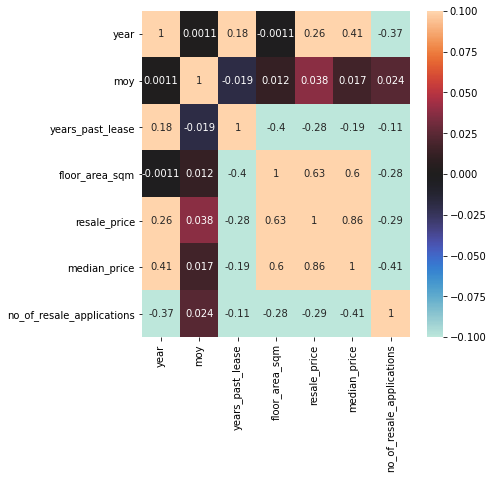

In [19]:
plt.subplots(figsize=(6, 6))
data_merged['year'] = data_merged['year'].astype('int')
_ = sns.heatmap(data_merged.corr(),annot=True, vmin=-0.1, vmax=0.1,center=0)

## Missing Values
There are some missing values in the median price and number of resale application columns. However, since XGBoost can naturally handle missing values we do not need to worry about it.

In [20]:
print(f"{set(data['town'].unique()) - set(median_data['town'].unique())} town is missing in the median data")
#one town bukit_timah missing from median prices data
print(f"{set(data['flat_type'].unique()) - set(median_data['flat_type'].unique())} flat types are missing in median data")
#three room types missing in median prices
#also data from 2020 q1 missing

{'bukit_timah'} town is missing in the median data
{'1_room', 'multi_generation'} flat types are missing in median data


In [21]:
#Tree based models should handle this, we do not try to explore any imputation
missingValues(data_merged)

Dataframe has 13 columns.
             There are 2             columns that have missing values.


,Missing Values,% of Total Values
median_price,22679,8.3
no_of_resale_applications,106,0.0


## Use data till 2018 for train validation
Split the data into train (previous n years) and validation (next 1 year). Since our task is to predict future prices I treat this as a time series problem where we use previous time window to train the model and test it on the next period. The custom **trainTest** split function does this splitting. For the task we use 2014-2018 data for train validation and 2019 as test period. Also I did this sliding window operation over previous years to test the model over various other periods. Model performance was consistent. I also used the training period length as a hyper-parameter. 4 years seem to be a good choice since it ensures sufficient number of training examples, looks back to enough history for 1 year ahead prediction.   

In [22]:
data_full, features = getFeatures(data_merged, oneHotEn=['flat_model', 'flat_type', 'storey_range', 'town'])
print(f'Total number of features {len(features)}')
X_train, X_valid, y_train, y_valid = trainTest(data_full, test_year=2018, n_prev=4)
print(f'Length of training dataset {len(X_train)}')
print(f'Length of validation dataset {len(X_valid)}')
missingValues(X_train)

Total number of features 86
Length of training dataset 73758
Length of validation dataset 21875
Dataframe has 86 columns.
             There are 2             columns that have missing values.


,Missing Values,% of Total Values
median_price,5844,7.9
no_of_resale_applications,12,0.0


## Model: XGBoost
For this prediction task XGBoost is a natural choice:
1. No data transformation needed (like normalization)
2. Handle missing values
3. Usually does not overfit even with lots of features
4. Very fast implementation
5. Easy hyper-parameter tuning 
6. Also in similar problems XGBoost has been the first choice by the practitioners

I also tried random forest which works out of the box in many problems, but XGBoost seems to be beating RF. I did not tried much of hyper-parameter tuning for RF.

In [23]:
#To check how does the model perform without most important features
#X_train.drop(columns=['median_price', 'block', 'street_name', 'years_past_lease', 'year', 'moy'], inplace=True)
#X_valid.drop(columns=['median_price', 'block', 'street_name', 'years_past_lease', 'year', 'moy'], inplace=True)
#features = list(set(features)-{'price', 'block', 'street_name', 'years_past_lease', 'year', 'moy'})
_, yp_valid, yp_train = XGBoost(X_train, X_valid, y_train, y_valid, features, verbose=True)

Traing model..
[0]	train-rmse:12.0814	eval-rmse:12.0731	train-rmspe:0.999997	eval-rmspe:0.999996
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:11.7189	eval-rmse:11.7111	train-rmspe:0.999994	eval-rmspe:0.999994
[2]	train-rmse:11.3675	eval-rmse:11.3596	train-rmspe:0.99999	eval-rmspe:0.99999
[3]	train-rmse:11.0266	eval-rmse:11.0192	train-rmspe:0.999986	eval-rmspe:0.999985
[4]	train-rmse:10.6959	eval-rmse:10.6888	train-rmspe:0.999979	eval-rmspe:0.999979
[5]	train-rmse:10.3751	eval-rmse:10.368	train-rmspe:0.99997	eval-rmspe:0.99997
[6]	train-rmse:10.064	eval-rmse:10.0569	train-rmspe:0.999958	eval-rmspe:0.999958
[7]	train-rmse:9.76209	eval-rmse:9.7555	train-rmspe:0.999943	eval-rmspe:0.999942
[8]	train-rmse:9.4694	eval-rmse:9.46259	train-rmspe:0.999923	eval-rmspe:0.999921
[9]	train-rmse:9.18536	eval-rmse:9.17862	train-rmspe:0.999897	eval-rmspe:0.999895
[10]	train-rmse:8.90983	eval

# Analyze percentage error
1. Although for model evaluation I used RMSPE and RMSE as metrics for explanation I believe *percentage percentage* error is more intuitive 
2. The error percentage on the validation set seems to be slightly left skewed.
3. More importantly the correlation plot suggests there is some posivie correlation between percentage error and resale price. To fix this a first approach is to callibrate the predicted values without affecting the other performance metrics.

Average Percentage Error on validation set 7.196 %


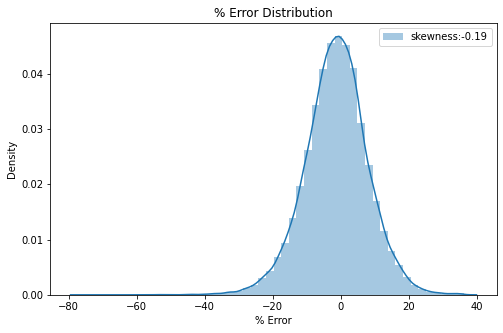

In [24]:
pError = percentError(yp_valid, y_valid)
fig, ax = plt.subplots(figsize=(8, 5))
g1 = sns.distplot(pError,hist = True,label='skewness:{:.2f}'.format(pError.skew()),ax = ax)
g1.legend()
g1.set(xlabel = '% Error', ylabel = 'Density', title = '% Error Distribution')
print(f'Average Percentage Error on validation set {round(np.mean(np.abs(pError)), 3)} %')

Correlation between validation percentage error and true value 0.54


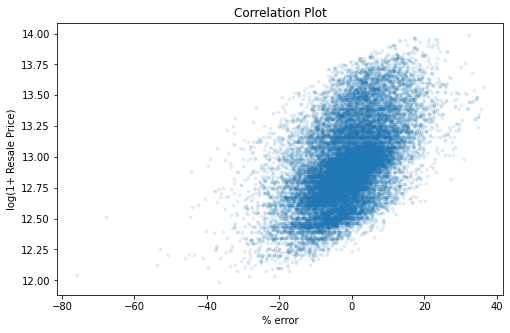

In [25]:
fig = plt.figure(figsize=(8, 5))
plt.scatter(pError, y_valid, s=7, alpha=0.1)
plt.xlabel("% error")
plt.ylabel('log(1+ Resale Price)')
plt.title('Correlation Plot')
print(f'Correlation between validation percentage error and true value {round(np.corrcoef(pError, y_valid)[0,1], 2)}')

# Model calibration
We observe higher resale prices are underestimated and lower resale prices are overestimated by the model. To get more accurate values for those away from mean prices we can do a callibraiton. I do an affine transformation (with linear assumption) of the range of values (price - avg(price)) in the training dataset to (0.99, 1.01). Formula: https://math.stackexchange.com/questions/377169/going-from-a-value-inside-1-1-to-a-value-in-another-range . Then I calculate a multiplication factor for predicted value of price by looking how far and which direction the predicted prices away from the training mean. While calibration no validation/ test data set is used to ensure information leakage. This method did not affect the other evaluation metrics and also reduced the correlation.

Correlation between validation percentage error (after calibrating predictions) and true value 0.12
Average Percentage Error on validation set (after calibrating predictions) 6.81 %
RMSPE on validation set after calibration 0.089
---------------------------------------------------------------------------------------------------------


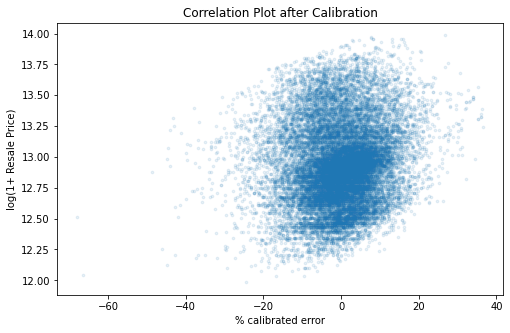

In [26]:
yp_valid_calb = calibrateModel(yp_valid, y_train)
pError_calb = percentError(yp_valid_calb, y_valid)

fig = plt.figure(figsize=(8, 5))
plt.scatter(pError_calb, y_valid, s=7, alpha=0.1)
plt.xlabel("% calibrated error")
plt.ylabel('log(1+ Resale Price)')
plt.title('Correlation Plot after Calibration')
print(f'Correlation between validation percentage error (after calibrating predictions) and true value {round(np.corrcoef(pError_calb, y_valid)[0,1], 2)}')
print(f'Average Percentage Error on validation set (after calibrating predictions) {round(np.mean(np.abs(pError_calb)), 3)} %')
print(f'RMSPE on validation set after calibration {round(rmspeXgb(yp_valid_calb, y_valid), 4)}')
print('---------------------------------------------------------------------------------------------------------')

## Test the final model on 2019 data
Train period (2013 - 2018) Test period 2019

In [27]:
test_year = 2019
X_train, X_test, y_train, y_test = trainTest(data_full, test_year=test_year, n_prev=5, rest_all=True)
print(f'Length of training dataset {len(X_train)}')
print(f'Length of test dataset {len(X_test)}')
model, yp_test, yp_train = XGBoost(X_train, X_test, y_train, y_test, features, verbose=False)
pTestError = percentError(yp_test, y_test)
print(f'Correlation between test percentage error (before calibrating predictions) and true value {round(np.corrcoef(pTestError, y_test)[0,1], 2)}')
print(f'Average Percentage Error on test set {round(np.mean(np.abs(pTestError)), 3)} %')
print('---------------------------------------------------------------------------------------------------------')
print('Calibrating predictions on test set..')
yp_test_calb = calibrateModel(yp_test, y_train)
pError_calb = percentError(yp_test_calb, y_test)
print(f'Correlation between test percentage error (after calibrating predictions) and true value {round(np.corrcoef(pError_calb, y_test)[0,1], 2)}')
print(f'Average Percentage Error on test set (after calibrating predictions) {round(np.mean(np.abs(pError_calb)), 3)} %')
print(f'RMSPE on test set after calibration {round(rmspeXgb(yp_test_calb, y_test), 4)}')

Length of training dataset 95633
Length of test dataset 24113
Training final model on data till 2018...
Predicting on test set
Train RMSPE 0.0685
Test RMSPE 0.0926
Correlation between test percentage error (before calibrating predictions) and true value 0.44
Average Percentage Error on test set 7.049 %
---------------------------------------------------------------------------------------------------------
Calibrating predictions on test set..
Correlation between test percentage error (after calibrating predictions) and true value 0.03
Average Percentage Error on test set (after calibrating predictions) 7.175 %
RMSPE on test set after calibration 0.0943


# Predicted Prices for 2019

In [28]:
output = data_merged[data_merged['year'] >= test_year]
output['Resale Price (Pred)'] = np.expm1(yp_test_calb)
output['Percentage error'] = pError_calb
output.drop(columns=['median_price', 'no_of_resale_applications'], inplace=True)
output.reset_index(drop=True, inplace=True)
output.to_pickle('./output/2019SingaporeHousePirces.pkl')
output.to_csv('./output/2019SingaporeHousePirces.csv', index=None)

output[0:5]

,year,moy,years_past_lease,block,flat_model,flat_type,floor_area_sqm,storey_range,town,street_name,resale_price,Resale Price (Pred),Percentage error
0,2019,1,16.0,314c,premium_apartment,4_room,92.0,07_to_09,sengkang,anchorvale_link,398000.0,370500.50000,6.909422
1,2019,1,18.0,303b,model_a2,4_room,86.0,10_to_12,sengkang,anchorvale_link,340000.0,347825.65625,-2.301664
2,2019,1,4.0,180d,model_a,3_room,67.0,13_to_15,sengkang,rivervale_cres,315000.0,313096.28125,0.604355
3,2019,1,12.0,265e,premium_apartment,4_room,92.0,13_to_15,sengkang,compassvale_bow,492000.0,445460.25000,9.459299
4,2019,1,17.0,322a,model_a2,4_room,86.0,04_to_06,sengkang,anchorvale_dr,382000.0,350942.03125,8.130358


## Feature Importance
The feature importance plot looks very insightful! We see the most important features in terms of weights (number of times a feature appears in the tree) are those which we can call as "Macro" variables like street_name, block, floor_area_sq, years_past_lease, median_price, no_of_applications, year, and moy (month of the year).

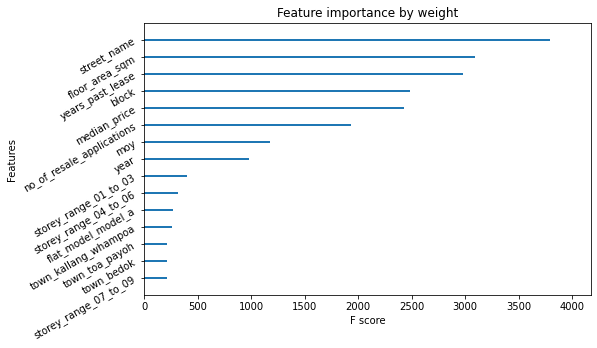

In [29]:
# plot feature importance, show top 15 features
fig, ax = plt.subplots(figsize=(8,5))
xgb.plot_importance(model, max_num_features= 15, height=0.1, ax=ax, importance_type="weight", grid=False, show_values=False, title='Feature importance by weight')
_ = plt.yticks(rotation=30)
#xgb.plot_importance(xgb, max_num_features= 15, height=0.1, ax=ax, importance_type="cover", show_values=False, title='Feature importance by cover')
#xgb.plot_importance(model, max_num_features= 15, height=0.1, ax=ax, importance_type="gain", grid=False, show_values=False, title='Feature importance by Gain')


# Model Performance

For the final prediction task we trained our model on 2014-2018 data to test the model on **2019 - 2020** data.
1. Testset RMSPE 0.0923 (uncalibrated)
2. Average Percentage Error on test set is 7.015 % (uncalibrated)
3. RMSPE on test set after calibration 0.0938
4. Average Percentage Error on test set after calibration 7.121 %
5. Model performance is stable

The above results are satisfactory

# Future Scopes

1. We may further try to explore other avaiable data which might be useful. We can try to fine tune the random forest model to see if it can achieve comparable result to XGBoost. Furthermore, we can try other linear models with more data preprocessing. 

2. Reference (Kaggle): Another idea might be use ensemble of multiple models (XGboost, Random forest). This needs more time and hyper-parameter tuning.

3. Another idea might be using a separate time-series model to predict housing price index or some similar indicator one period ahead and use it as a meta feature in our machine learning model.

However the above ideas may make the model more complex and less interpretable at the cost of more accurate predictions!



# Appendix (Explore some other ideas, not for presentation)
 Try Random Forest. The out of the box RF model does not perform better than XGBoost. However, at the moment we do not try to tune the RF model

In [30]:
# Try random forest model
X_train, X_valid, y_train, y_valid = trainTest(data_full, test_year=2019, n_prev=5, rest_all=True)

print('Fitting Random Forest model:')
X_train.fillna(0, inplace=True)
X_valid.fillna(0, inplace=True)

rf = RandomForestRegressor(n_estimators=300, max_depth=10)
rf.fit(X_train, y_train)

yp_valid = rf.predict(X_valid)
error = rmspeXgb(yp_valid, y_valid)
print(f'Validation RMSPE error {round(error,4)}')

Fitting Random Forest model:
Validation RMSPE error 0.1118


Random Forest model seems to be too much dependent on floor_area and street_name which is not desirable

Text(0.5, 1.0, 'Feature Importance')

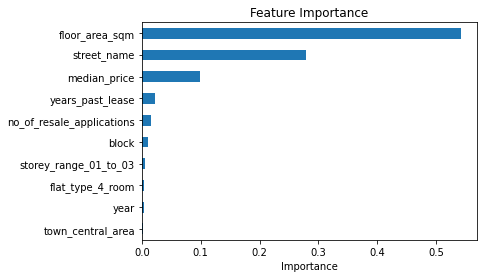

In [31]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).sort_values(ascending = True).plot(kind='barh')
plt.xlabel('Importance')
plt.title('Feature Importance')

Average Percentage Error on validation set 8.6 %


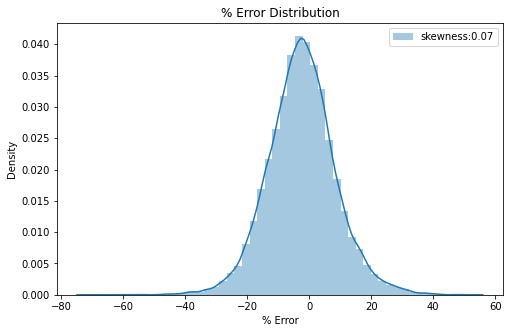

In [36]:
pError = percentError(yp_valid, y_valid)
fig, ax = plt.subplots(figsize=(8, 5))
g1 = sns.distplot(pError,hist = True,label='skewness:{:.2f}'.format(pError.skew()),ax = ax)
g1.legend()
g1.set(xlabel = '% Error', ylabel = 'Density', title = '% Error Distribution')
print(f'Average Percentage Error on validation set {round(np.mean(np.abs(pError)), 3)} %')

Correlation between validation percentage error and true value 0.61


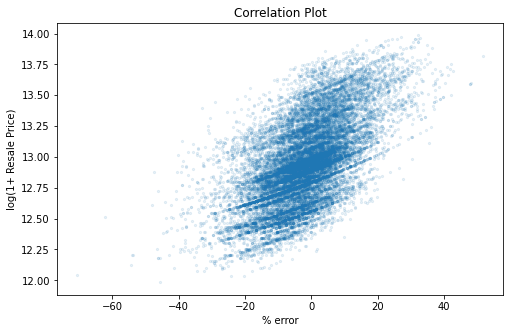

In [37]:
fig = plt.figure(figsize=(8, 5))
plt.scatter(pError, y_valid, s=5, alpha=0.1)
plt.xlabel("% error")
plt.ylabel('log(1+ Resale Price)')
plt.title('Correlation Plot')
print(f'Correlation between validation percentage error and true value {round(np.corrcoef(pError, y_valid)[0,1], 2)}')

In [38]:
data_merged[0:2]

,year,moy,years_past_lease,block,flat_model,flat_type,floor_area_sqm,storey_range,town,street_name,resale_price,median_price,no_of_resale_applications
0,2008,1,29.0,406,improved,2_room,44.0,10_to_12,ang_mo_kio,ang_mo_kio_ave_10,148000.0,NaN,67.0
1,2008,1,10.0,305,apartment,executive,141.0,16_to_18,sembawang,canberra_rd,440000.0,NaN,511.0


In [0]:
dummy = data[['year']]